# 05: Positional Encoding

*The fish learns where things are.*

---

In notebook 04, we added attention. The model could now look at all previous tokens and decide which ones mattered. But it had a blind spot: **it didn't know where anything was.**

Think about it. The attention mechanism computes Q·K similarity between tokens. If token A and token B have similar embeddings, they'll have similar queries and keys. The model can learn "attend to nouns" or "attend to verbs" based on *what* tokens are. But it can't learn "attend to the token 2 positions back" because nothing in the computation encodes position.

This matters. Language has structure that depends on position:
- The subject usually comes before the verb
- Adjectives come before nouns (in English)
- The most recent tokens are often most relevant
- Certain positions have grammatical expectations (first word capitalized, etc.)

**Positional encoding** gives each position a unique signature. We add a position-dependent vector to each token embedding, so the model can distinguish "the word 'dog' at position 3" from "the word 'dog' at position 50."

**What we expect:** Better perplexity. More grammatical outputs. The model can now learn position-dependent patterns, not just content-dependent ones.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import json
import math

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

Using device: mps


---

## 1. Data and Tokenizer

In [2]:
from transformers import GPT2TokenizerFast

class LilTokenizer:
    """Compact tokenizer for Lil Transformy."""
    
    def __init__(self, gpt2_to_compact, compact_to_gpt2, vocab_size):
        self.gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
        self.gpt2_to_compact = gpt2_to_compact
        self.compact_to_gpt2 = compact_to_gpt2
        self.vocab_size = vocab_size
        self.pad_id = 0
        self.unk_id = 1
        self.eos_id = 2
    
    def encode(self, text, add_eos=True):
        gpt2_tokens = self.gpt2_tokenizer.encode(text)
        compact_tokens = [self.gpt2_to_compact.get(t, self.unk_id) for t in gpt2_tokens]
        if add_eos:
            compact_tokens.append(self.eos_id)
        return compact_tokens
    
    def decode(self, token_ids):
        gpt2_tokens = []
        for tid in token_ids:
            if tid in [self.pad_id, self.unk_id, self.eos_id]:
                continue
            if tid in self.compact_to_gpt2:
                gpt2_tokens.append(self.compact_to_gpt2[tid])
        return self.gpt2_tokenizer.decode(gpt2_tokens)
    
    def decode_single(self, token_id):
        if token_id == self.pad_id:
            return '<pad>'
        if token_id == self.unk_id:
            return '<unk>'
        if token_id == self.eos_id:
            return '<eos>'
        if token_id in self.compact_to_gpt2:
            return self.gpt2_tokenizer.decode([self.compact_to_gpt2[token_id]])
        return '<???>'
    
    def __len__(self):
        return self.vocab_size
    
    @classmethod
    def load(cls, path):
        with open(path, 'r') as f:
            config = json.load(f)
        gpt2_to_compact = {int(k): v for k, v in config['gpt2_to_compact'].items()}
        compact_to_gpt2 = {int(k): v for k, v in config['compact_to_gpt2'].items()}
        return cls(gpt2_to_compact, compact_to_gpt2, config['vocab_size'])


tokenizer = LilTokenizer.load('tokenizer/tokenizer.json')
print(f"Vocabulary size: {len(tokenizer):,}")

Vocabulary size: 4,096


In [3]:
train_data = np.load('data/train_sequences.npy')
val_data = np.load('data/val_sequences.npy')

print(f"Training sequences: {train_data.shape}")
print(f"Validation sequences: {val_data.shape}")
print(f"Context length: {train_data.shape[1]}")

Training sequences: (1851532, 256)
Validation sequences: (18616, 256)
Context length: 256


---

## 2. What Is Positional Encoding?

The problem: attention is **permutation equivariant** with respect to position. If you shuffle the input tokens (ignoring the causal mask for a moment), the attention patterns shuffle the same way. There's nothing in Q·K that says "position 3 is special" or "positions close together should interact more."

The solution: **add position information to the embeddings** before attention sees them.

### Two Main Approaches

**1. Learned positional embeddings:**
```python
self.pos_embedding = nn.Embedding(max_seq_len, d_model)
x = token_embedding + pos_embedding
```
Each position (0, 1, 2, ..., 255) gets its own learned vector. Simple and effective. This is what GPT-2 uses.

**2. Sinusoidal positional encoding:**
```python
PE(pos, 2i) = sin(pos / 10000^(2i/d))
PE(pos, 2i+1) = cos(pos / 10000^(2i/d))
```
A fixed pattern of sines and cosines at different frequencies. No learned parameters. This is what the original "Attention Is All You Need" paper used.

### We'll Use Learned Embeddings

Why?
- Simpler to understand
- Works just as well in practice
- GPT-2, GPT-3, and many other models use this approach

The sinusoidal approach has a theoretical advantage (it can extrapolate to longer sequences), but we're not doing that here. For a fixed context length, learned embeddings are totally fine.

### How It Works

Before:
```
token_3 → embedding[token_3] → attention sees: "some word"
```

After:
```
token_3 → embedding[token_3] + pos_embedding[3] → attention sees: "some word at position 3"
```

That's it. We just add a position-dependent vector to each token embedding. The attention mechanism then sees both *what* the token is and *where* it is.

---

## 3. Visualizing Positional Embeddings

Let's see what learned positional embeddings look like after training. But first, let's initialize them randomly and see the starting point.

Positional embedding shape: (256, 128)
  - 256 positions
  - 128 dimensions per position



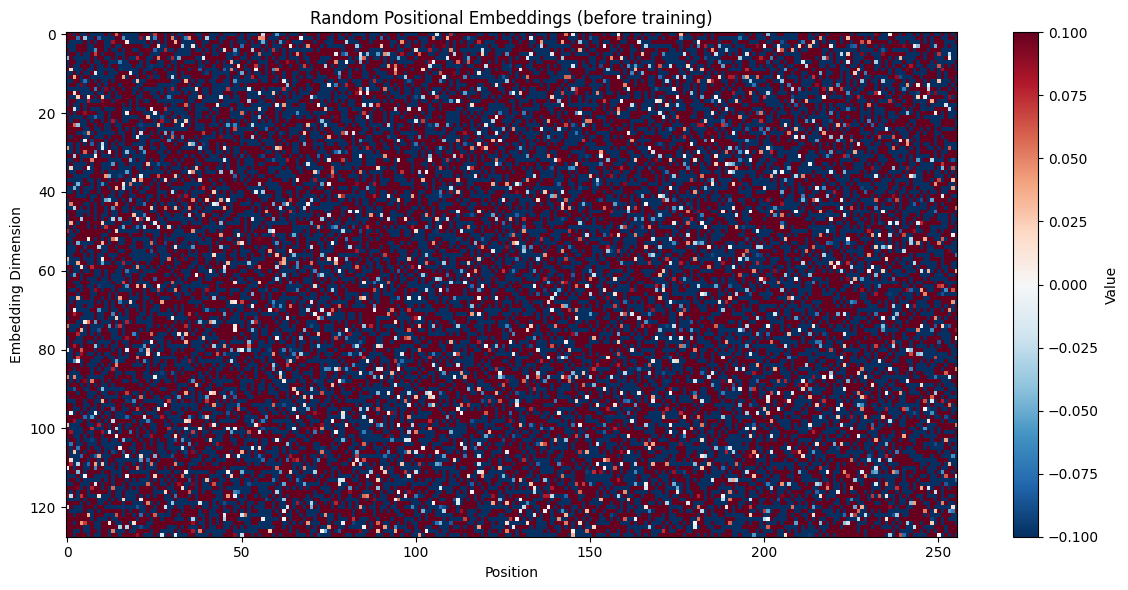

Pure noise. Each position has a random vector.
After training, we'll see structure emerge.


In [4]:
# Create random positional embeddings to see what they look like at init
MAX_SEQ_LEN = 256
D_MODEL = 128

# Random initialization (what we start with)
random_pos_embed = nn.Embedding(MAX_SEQ_LEN, D_MODEL)

# Get the embedding weights
pos_weights = random_pos_embed.weight.detach().numpy()  # [256, 128]

print(f"Positional embedding shape: {pos_weights.shape}")
print(f"  - {MAX_SEQ_LEN} positions")
print(f"  - {D_MODEL} dimensions per position")
print()

# Visualize as heatmap
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(pos_weights.T, aspect='auto', cmap='RdBu_r', vmin=-0.1, vmax=0.1)
ax.set_xlabel('Position')
ax.set_ylabel('Embedding Dimension')
ax.set_title('Random Positional Embeddings (before training)')
plt.colorbar(im, ax=ax, label='Value')
plt.tight_layout()
plt.show()

print("Pure noise. Each position has a random vector.")
print("After training, we'll see structure emerge.")

---

## 4. The Model

Same as notebook 04, but with positional embeddings added to token embeddings.

In [5]:
class CausalSelfAttention(nn.Module):
    """
    Single-head causal self-attention.
    (Same as notebook 04)
    """
    
    def __init__(self, d_model, max_seq_len=256):
        super().__init__()
        self.d_model = d_model
        
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)
        
        mask = torch.triu(torch.ones(max_seq_len, max_seq_len), diagonal=1).bool()
        self.register_buffer('mask', mask)
        self.scale = math.sqrt(d_model)
    
    def forward(self, x, return_attention=False):
        batch_size, seq_len, _ = x.shape
        
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)
        
        scores = (Q @ K.transpose(-2, -1)) / self.scale
        scores = scores.masked_fill(self.mask[:seq_len, :seq_len], float('-inf'))
        attn_weights = F.softmax(scores, dim=-1)
        attn_output = attn_weights @ V
        output = self.W_o(attn_output)
        
        if return_attention:
            return output, attn_weights
        return output

In [6]:
class PositionalAttentionLM(nn.Module):
    """
    Language model with attention AND positional encoding.
    
    Architecture:
        Token → Token Embedding + Position Embedding → Attention → Unembed → Logits
    
    The only change from notebook 04: we add learned positional embeddings
    to the token embeddings before attention.
    """
    
    def __init__(self, vocab_size, d_model, max_seq_len=256):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        
        # Token embedding: what is this token?
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        
        # Position embedding: where is this token?
        self.position_embedding = nn.Embedding(max_seq_len, d_model)
        
        # Attention layer
        self.attention = CausalSelfAttention(d_model, max_seq_len)
        
        # Output projection
        self.unembed = nn.Linear(d_model, vocab_size)
    
    def forward(self, x, return_attention=False):
        """
        Args:
            x: Input token IDs, shape [batch, seq_len]
        
        Returns:
            logits: Shape [batch, seq_len, vocab_size]
        """
        batch_size, seq_len = x.shape
        
        # Token embeddings
        tok_emb = self.token_embedding(x)  # [batch, seq_len, d_model]
        
        # Position embeddings
        positions = torch.arange(seq_len, device=x.device)  # [seq_len]
        pos_emb = self.position_embedding(positions)  # [seq_len, d_model]
        
        # Combine: token + position
        embedded = tok_emb + pos_emb  # [batch, seq_len, d_model]
        
        # Apply attention
        if return_attention:
            attended, attn_weights = self.attention(embedded, return_attention=True)
        else:
            attended = self.attention(embedded)
        
        # Project to vocabulary
        logits = self.unembed(attended)
        
        if return_attention:
            return logits, attn_weights
        return logits
    
    def generate(self, prompt_tokens, max_new_tokens=50, temperature=1.0):
        """Generate tokens autoregressively."""
        self.eval()
        tokens = list(prompt_tokens)
        generated = []
        
        with torch.no_grad():
            for _ in range(max_new_tokens):
                context = tokens[-self.max_seq_len:]
                x = torch.tensor([context], device=next(self.parameters()).device)
                
                logits = self.forward(x)
                next_logits = logits[0, -1]
                
                probs = F.softmax(next_logits / temperature, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1).item()
                
                generated.append(next_token)
                tokens.append(next_token)
                
                if next_token == 2:  # EOS
                    break
        
        return generated

In [7]:
# === Model Parameters ===
VOCAB_SIZE = len(tokenizer)  # 4096
D_MODEL = 128
MAX_SEQ_LEN = 256

# Create model
model = PositionalAttentionLM(VOCAB_SIZE, D_MODEL, MAX_SEQ_LEN).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
pos_params = MAX_SEQ_LEN * D_MODEL

print(f"Total parameters: {num_params:,}")
print()
print("Breakdown:")
print(f"  Token embedding:    {VOCAB_SIZE} × {D_MODEL} = {VOCAB_SIZE * D_MODEL:,}")
print(f"  Position embedding: {MAX_SEQ_LEN} × {D_MODEL} = {pos_params:,}  ← NEW")
print(f"  Attention:          4 × {D_MODEL} × {D_MODEL} = {4 * D_MODEL * D_MODEL:,}")
print(f"  Unembed:            {D_MODEL} × {VOCAB_SIZE} + {VOCAB_SIZE} = {D_MODEL * VOCAB_SIZE + VOCAB_SIZE:,}")
print()
print(f"Notebook 04 had {1118208:,} params.")
print(f"We added {pos_params:,} for positional embeddings.")

Total parameters: 1,150,976

Breakdown:
  Token embedding:    4096 × 128 = 524,288
  Position embedding: 256 × 128 = 32,768  ← NEW
  Attention:          4 × 128 × 128 = 65,536
  Unembed:            128 × 4096 + 4096 = 528,384

Notebook 04 had 1,118,208 params.
We added 32,768 for positional embeddings.


---

## 5. Training

Same setup as notebook 04. One epoch this time—optimizing for understanding per unit wall-clock time.

In [8]:
# === Training Parameters ===
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
NUM_EPOCHS = 1  # One epoch: ~15 minutes
EVAL_EVERY = 500

def make_batch(data, batch_indices):
    """Create a training batch."""
    sequences = data[batch_indices]
    x = torch.tensor(sequences[:, :-1], dtype=torch.long, device=device)
    y = torch.tensor(sequences[:, 1:], dtype=torch.long, device=device)
    return x, y

def evaluate(model, data, num_batches=50):
    """Evaluate model on validation data."""
    model.eval()
    total_loss = 0
    total_tokens = 0
    
    indices = np.random.choice(len(data), size=num_batches * BATCH_SIZE, replace=False)
    
    with torch.no_grad():
        for i in range(num_batches):
            batch_idx = indices[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
            x, y = make_batch(data, batch_idx)
            
            logits = model(x)
            logits_flat = logits.view(-1, VOCAB_SIZE)
            y_flat = y.view(-1)
            
            loss = F.cross_entropy(logits_flat, y_flat)
            
            total_loss += loss.item() * y_flat.numel()
            total_tokens += y_flat.numel()
    
    model.train()
    avg_loss = total_loss / total_tokens
    return {'loss': avg_loss, 'perplexity': math.exp(avg_loss)}


# Setup
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
steps_per_epoch = len(train_data) // BATCH_SIZE
total_steps = steps_per_epoch * NUM_EPOCHS

print(f"Steps per epoch: {steps_per_epoch:,}")
print(f"Total steps: {total_steps:,}")
print(f"Expected time: ~15 minutes")

Steps per epoch: 28,930
Total steps: 28,930
Expected time: ~15 minutes


In [9]:
# Training loop
history = {'train_loss': [], 'val_loss': [], 'val_perplexity': []}

print("Starting training...")
print("=" * 60)

step = 0
running_loss = 0

for epoch in range(NUM_EPOCHS):
    perm = np.random.permutation(len(train_data))
    epoch_pbar = tqdm(range(steps_per_epoch), desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    
    for batch_num in epoch_pbar:
        batch_idx = perm[batch_num * BATCH_SIZE:(batch_num + 1) * BATCH_SIZE]
        x, y = make_batch(train_data, batch_idx)
        
        optimizer.zero_grad()
        logits = model(x)
        
        logits_flat = logits.view(-1, VOCAB_SIZE)
        y_flat = y.view(-1)
        loss = F.cross_entropy(logits_flat, y_flat)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        step += 1
        
        if step % EVAL_EVERY == 0:
            avg_train_loss = running_loss / EVAL_EVERY
            val_metrics = evaluate(model, val_data)
            
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(val_metrics['loss'])
            history['val_perplexity'].append(val_metrics['perplexity'])
            
            epoch_pbar.set_postfix({
                'loss': f"{avg_train_loss:.3f}",
                'val_loss': f"{val_metrics['loss']:.3f}",
                'ppl': f"{val_metrics['perplexity']:.1f}"
            })
            
            running_loss = 0

print("\nTraining complete!")

Starting training...


Epoch 1/1:   0%|          | 0/28930 [00:00<?, ?it/s]


Training complete!


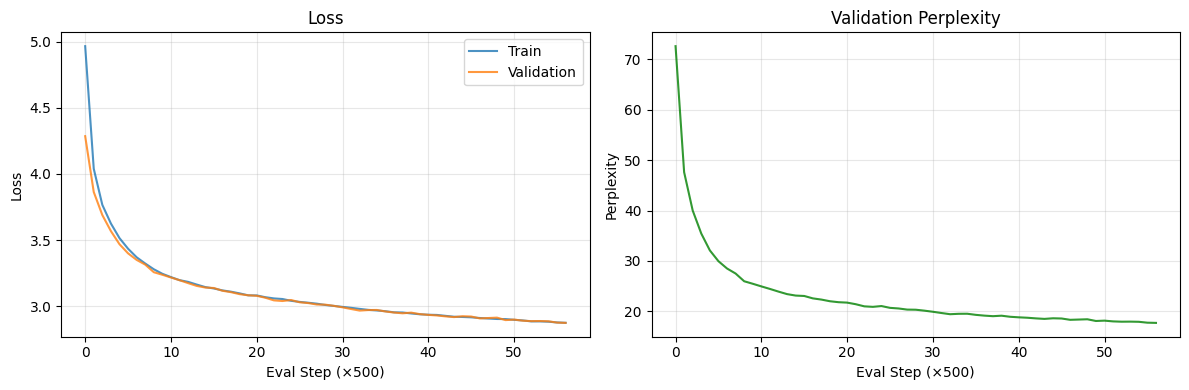


Final validation loss: 2.873
Final validation perplexity: 17.7


In [10]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_loss'], label='Train', alpha=0.8)
axes[0].plot(history['val_loss'], label='Validation', alpha=0.8)
axes[0].set_xlabel(f'Eval Step (×{EVAL_EVERY})')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['val_perplexity'], color='green', alpha=0.8)
axes[1].set_xlabel(f'Eval Step (×{EVAL_EVERY})')
axes[1].set_ylabel('Perplexity')
axes[1].set_title('Validation Perplexity')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('05_training_curves.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nFinal validation loss: {history['val_loss'][-1]:.3f}")
print(f"Final validation perplexity: {history['val_perplexity'][-1]:.1f}")

---

## 6. Visualizing Learned Positional Embeddings

Now let's see what the model learned about position.

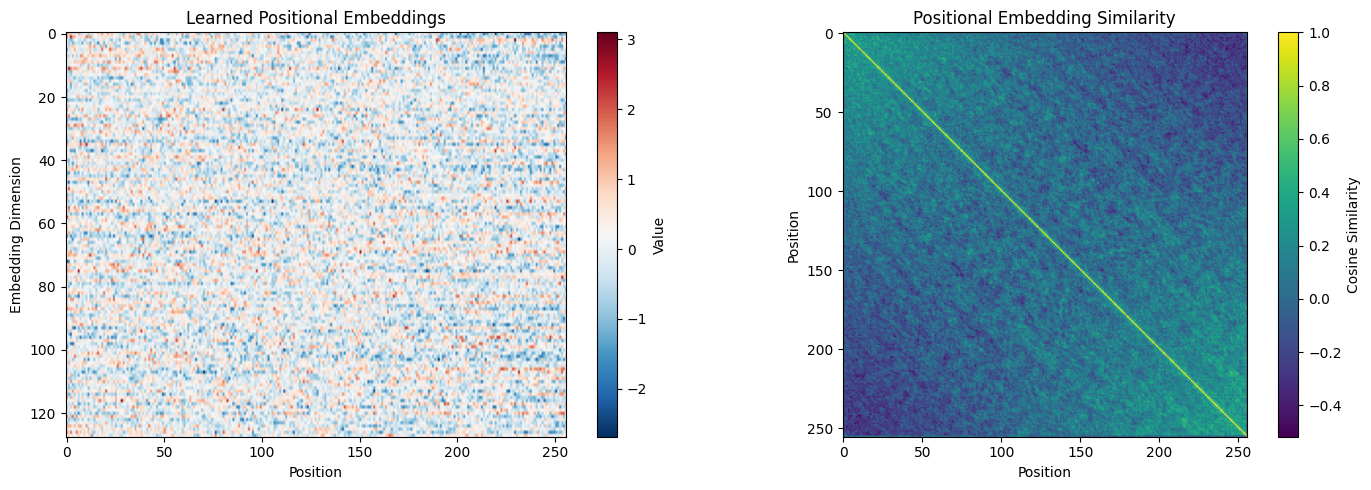

Left: The raw positional embeddings. Look for patterns across positions.
Right: Similarity between positions. Nearby positions should be more similar.


In [11]:
# Get the learned positional embeddings
pos_weights = model.position_embedding.weight.detach().cpu().numpy()  # [256, 128]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap
ax = axes[0]
im = ax.imshow(pos_weights.T, aspect='auto', cmap='RdBu_r')
ax.set_xlabel('Position')
ax.set_ylabel('Embedding Dimension')
ax.set_title('Learned Positional Embeddings')
plt.colorbar(im, ax=ax, label='Value')

# Similarity matrix: how similar are different positions?
ax = axes[1]
pos_tensor = torch.tensor(pos_weights)
# Normalize for cosine similarity
pos_norm = pos_tensor / pos_tensor.norm(dim=1, keepdim=True)
similarity = (pos_norm @ pos_norm.T).numpy()

im = ax.imshow(similarity, cmap='viridis')
ax.set_xlabel('Position')
ax.set_ylabel('Position')
ax.set_title('Positional Embedding Similarity')
plt.colorbar(im, ax=ax, label='Cosine Similarity')

plt.tight_layout()
plt.savefig('05_positional_embeddings.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("Left: The raw positional embeddings. Look for patterns across positions.")
print("Right: Similarity between positions. Nearby positions should be more similar.")

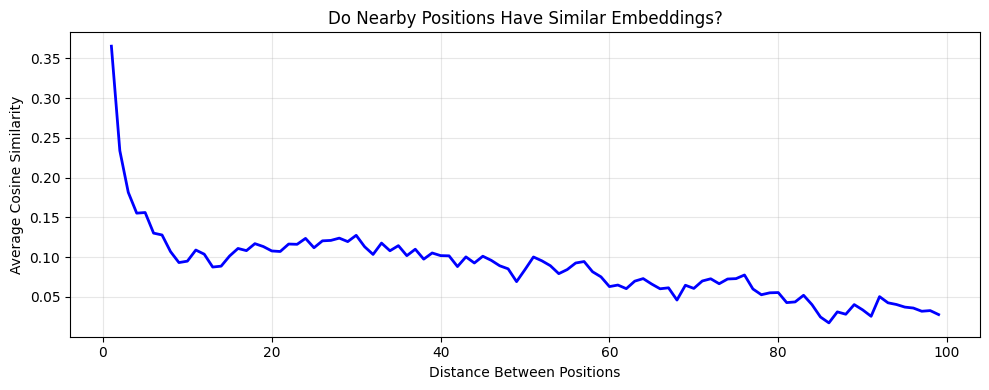

Similarity at distance 1: 0.365
Similarity at distance 10: 0.095
Similarity at distance 50: 0.084

If the model learned that nearby positions are related, we'd see
higher similarity for nearby positions (small distance).


In [12]:
# Check if nearby positions are more similar
def avg_similarity_at_distance(similarity_matrix, distance):
    """Average similarity between positions that are `distance` apart."""
    n = similarity_matrix.shape[0]
    if distance >= n:
        return 0
    sims = [similarity_matrix[i, i + distance] for i in range(n - distance)]
    return np.mean(sims)

distances = range(1, 100)
avg_sims = [avg_similarity_at_distance(similarity, d) for d in distances]

plt.figure(figsize=(10, 4))
plt.plot(distances, avg_sims, 'b-', linewidth=2)
plt.xlabel('Distance Between Positions')
plt.ylabel('Average Cosine Similarity')
plt.title('Do Nearby Positions Have Similar Embeddings?')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Similarity at distance 1: {avg_similarity_at_distance(similarity, 1):.3f}")
print(f"Similarity at distance 10: {avg_similarity_at_distance(similarity, 10):.3f}")
print(f"Similarity at distance 50: {avg_similarity_at_distance(similarity, 50):.3f}")
print()
print("If the model learned that nearby positions are related, we'd see")
print("higher similarity for nearby positions (small distance).")

---

## 7. Comparison: Did Position Help?

In [13]:
# Load previous results
checkpoint_03 = torch.load('03_bigram.pt', map_location='cpu', weights_only=False)
checkpoint_04 = torch.load('04_attention.pt', map_location='cpu', weights_only=False)

print("=" * 60)
print("COMPARISON: How Much Did Position Help?")
print("=" * 60)
print()
print(f"{'Model':<30} {'Params':<12} {'Epochs':<8} {'Val PPL':<10}")
print("-" * 60)
print(f"{'03: Bigram':<30} {'1,052,672':<12} {'1':<8} {checkpoint_03['history']['val_perplexity'][-1]:<10.1f}")
print(f"{'04: + Attention':<30} {'1,118,208':<12} {'3':<8} {checkpoint_04['history']['val_perplexity'][-1]:<10.1f}")
print(f"{'05: + Position (this)':<30} {f'{num_params:,}':<12} {'1':<8} {history['val_perplexity'][-1]:<10.1f}")
print()
print("Note: 04 trained for 3 epochs, 05 trained for 1 epoch.")
print("For fair comparison, we'd need to retrain 04 for 1 epoch.")

COMPARISON: How Much Did Position Help?

Model                          Params       Epochs   Val PPL   
------------------------------------------------------------
03: Bigram                     1,052,672    1        35.8      
04: + Attention                1,118,208    3        25.0      
05: + Position (this)          1,150,976    1        17.7      

Note: 04 trained for 3 epochs, 05 trained for 1 epoch.
For fair comparison, we'd need to retrain 04 for 1 epoch.


---

## 8. Generation

In [14]:
def generate_and_print(prompt, max_tokens=50, temperature=1.0):
    """Generate from a prompt and print results."""
    prompt_tokens = tokenizer.encode(prompt, add_eos=False)
    generated_tokens = model.generate(prompt_tokens, max_new_tokens=max_tokens, temperature=temperature)
    generated_text = tokenizer.decode(generated_tokens)
    
    print(f"Prompt: {prompt}")
    print(f"Generated: {generated_text}")
    print()


print("=" * 60)
print("GENERATION TEST")
print("=" * 60)
print()

test_prompts = [
    "Once upon a time",
    "The little girl",
    "Once upon a time there was a little girl named Lily. She",
    "The boy was sad because his toy was broken. His mom said",
]

for prompt in test_prompts:
    generate_and_print(prompt, max_tokens=40)

GENERATION TEST

Prompt: Once upon a time
Generated:  there were two Sam. They were lots of healthy friends and fine. They were happy. They all made Lily happy.

Prompt: The little girl
Generated:  and Lucy knew what was inside. She saw that something wanted they wanted to solve it.

She moved on her head to the mystery to fix something terrible. She took out a cloth,

Prompt: Once upon a time there was a little girl named Lily. She
Generated:  loved to play outside and make it it. One day, she was very hot outside and started painting.

Lily saw a big picture of something rare. She drew drawing she went outside and

Prompt: The boy was sad because his toy was broken. His mom said
Generated:  Tim, Timmymymymy's mommymymymymymymymymymymymymymymymymymymymymymymymymymymymymymymy



---

## 9. Visualizing Attention Patterns

Now that the model knows position, do the attention patterns look different?

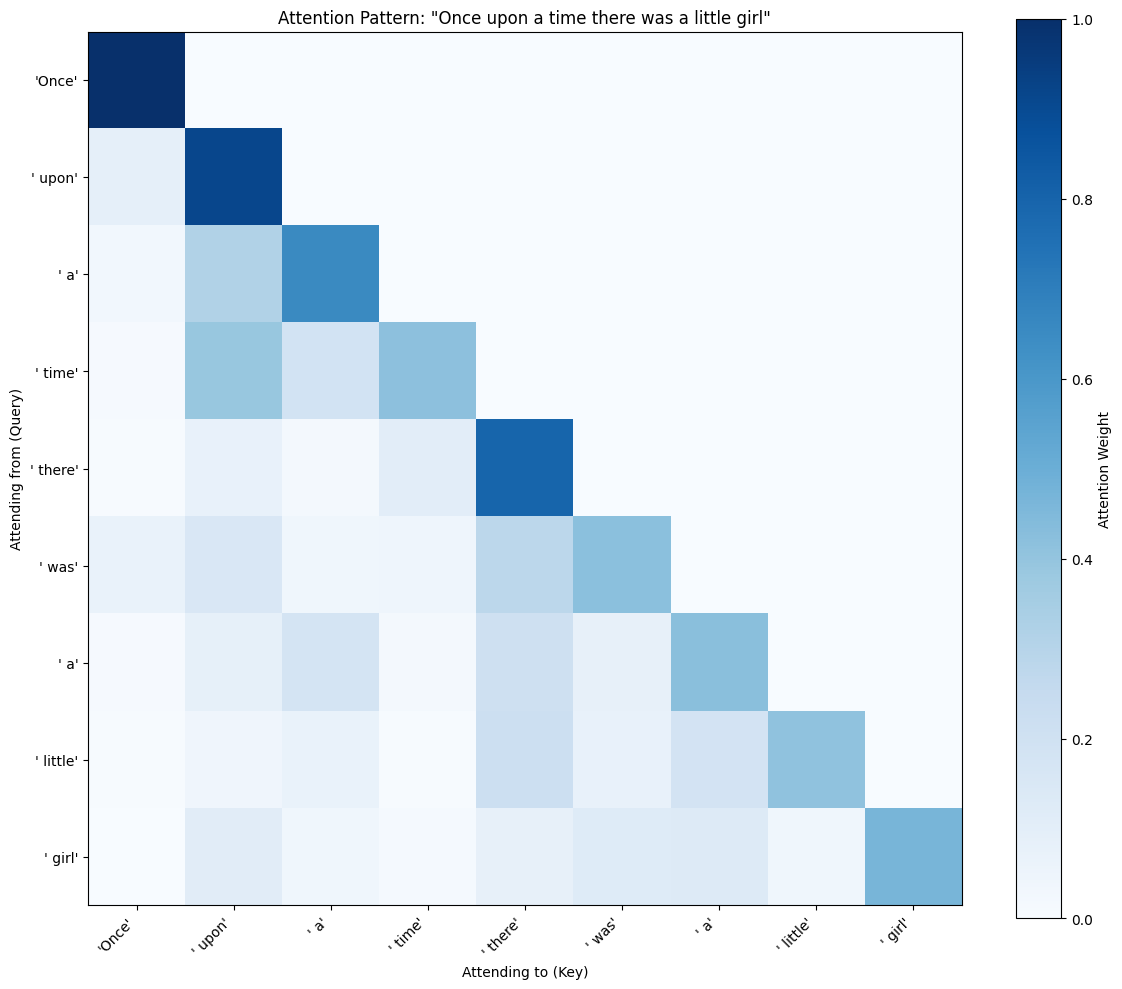

Look for:
  - Diagonal patterns (attending to recent tokens)
  - Consistent patterns at specific positions
  - Different behavior at sentence start vs. middle


In [15]:
def visualize_attention(text, figsize=(12, 10)):
    """Visualize attention patterns for a given text."""
    tokens = tokenizer.encode(text, add_eos=False)
    token_strs = [tokenizer.decode_single(t) for t in tokens]
    
    model.eval()
    with torch.no_grad():
        x = torch.tensor([tokens], device=device)
        logits, attn_weights = model(x, return_attention=True)
    
    weights = attn_weights[0].cpu().numpy()
    
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(weights, cmap='Blues')
    
    n_tokens = len(tokens)
    ax.set_xticks(range(n_tokens))
    ax.set_yticks(range(n_tokens))
    ax.set_xticklabels([repr(s) for s in token_strs], rotation=45, ha='right')
    ax.set_yticklabels([repr(s) for s in token_strs])
    
    ax.set_xlabel('Attending to (Key)')
    ax.set_ylabel('Attending from (Query)')
    ax.set_title(f'Attention Pattern: "{text}"')
    
    plt.colorbar(im, ax=ax, label='Attention Weight')
    plt.tight_layout()
    
    return fig, weights, token_strs


fig, weights, tokens = visualize_attention("Once upon a time there was a little girl")
plt.savefig('05_attention_pattern.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("Look for:")
print("  - Diagonal patterns (attending to recent tokens)")
print("  - Consistent patterns at specific positions")
print("  - Different behavior at sentence start vs. middle")

---

## Summary

### What We Added

**Learned positional embeddings:** A vector for each position (0-255) that gets added to the token embedding.

```python
embedded = token_embedding(x) + position_embedding(positions)
```

That's the entire change. Everything else is the same as notebook 04.

### What Position Gives Us

The model can now learn position-dependent patterns:
- "The first position often has a capital letter"
- "Attend more to recent tokens"
- "Position 2 after a period expects a capital"

Without position, attention could only learn content-based patterns ("attend to nouns"). Now it can learn structural patterns too.

### What's Still Missing

- **Feedforward network:** Per-token processing after attention gathers context
- **Residual connections:** Information can flow around layers, not just through them
- **Layer normalization:** Stabilizes training
- **Multiple heads:** Parallel attention patterns

### The Lesson

Attention alone is permutation-equivariant—it doesn't know where things are. Adding positional encoding breaks this symmetry and lets the model learn that position matters.

In [16]:
# Save model checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'vocab_size': VOCAB_SIZE,
    'd_model': D_MODEL,
    'max_seq_len': MAX_SEQ_LEN,
    'history': history,
}

torch.save(checkpoint, '05_positional.pt')
print("Model saved to 05_positional.pt")

Model saved to 05_positional.pt


In [17]:
print("=" * 60)
print("NOTEBOOK 05 COMPLETE")
print("=" * 60)
print(f"\nArchitecture: Token + Position → Attention → Unembed")
print(f"Parameters: {num_params:,}")
print(f"Training: {NUM_EPOCHS} epoch")
print(f"Final perplexity: {history['val_perplexity'][-1]:.1f}")
print()
print("The fish knows where things are.")
print("Next: Give it a brain (feedforward network).")

NOTEBOOK 05 COMPLETE

Architecture: Token + Position → Attention → Unembed
Parameters: 1,150,976
Training: 1 epoch
Final perplexity: 17.7

The fish knows where things are.
Next: Give it a brain (feedforward network).
